# Lab 04
Antoni Zięciak (zieciak@student.agh.edu.pl)

## Advection-diffusion equation
This equation (which is shown below) may describe concentration $C$ of polutants in the fluid, assuming that the fluid is flowing with speed $u$ and diffusion coefficient of this polutant in that fluid is equal to $D$. 
$$\frac{\partial C}{\partial t}+u\frac{\partial C}{\partial x}-D\frac{\partial^2C}{\partial x^2}=0$$

### Analycitacal solution

Assuming that:

- $0 \leq x \leq 1$ and $t \geq 0$,
- boundary conditions: $C(0,t) = C(1,t) = 0; t \geq 0$,
- initial condition: $C(x, 0) = sin(\pi x); 0 \leq x \leq 1$,
- $D$ is constant,
- $u$ is constant,

the equation has analitical solution given by the formula:
$$C(x,t) = e^{-(\frac{u^2}{4D} + \pi^2D)t}sin(\pi x)$$

In [3]:
import numpy as np

class AnalSolution:
    def __init__(self, *, u, D):
        self.u = u
        self.D = D

    def __call__(self, x, t):
        return np.exp(-(np.square(self.u) / (4 * self.D) + np.square(np.pi) * self.D) * t) * np.sin(np.pi * x)

### Numerical solution

The numerical solution to this equation could be modeled using upwind scheme from advection equation. Taking into account the fact that upwind method was created for equation $\frac{\partial C}{\partial t}=-u\frac{\partial C}{\partial x}$, as u in this scenario we can treat $u-D\frac{\partial_x C}{C}C$, which is just a sum of the $u$ for the upwind method of both diffusion and advection. That implies that the Curant number is sum of the Curant numbers of those two, so it must be calculated for each step. 

In [19]:
def F(psi_l, psi_r, C):
    return .5 * (C + abs(C)) * psi_l + \
           .5 * (C - abs(C)) * psi_r

class shift:
    def __init__(self, *, add, sub):
        self.add = add
        self.sub = sub

    def __radd__(self, o):
        return slice(o.start + self.add, o.stop + self.add)

    def __rsub__(self, o):
        return slice(o.start - self.sub, o.stop - self.sub)
    
class NumSolution:
    def __init__(self, *, t_max, u, D, nt, dx):
        self.one = shift(add=1, sub=1)
        self.hlf = shift(add=0, sub=1)

        self.u = u
        self.nt = nt
        self.dt = t_max/nt
        self.D = D
        self.dx = dx

        self.anal = AnalSolution(u=self.u, D=self.D)

    def __call__(self, x):
        initial = self.anal(x, 0)
        C = np.zeros(len(initial) - 1)

        nx = len(x)

        i = slice(1, nx-1)
        im = slice(1, nx)

        for j in range(self.nt):
            C[im - self.hlf] = self.dt / self.dx * (self.u - self.D * (initial[im] - initial[im-self.one]) / self.dx * 2 / (initial[im] + initial[im-self.one]))
            assert max(abs(C)) <= 1 
            initial[i] = initial[i] - (F(initial[i], initial[i+self.one], C[i+self.hlf]) - F(initial[i-self.one], initial[i], C[i-self.hlf]))

        return initial

In [20]:
dx = 0.01
t_max = 5
num = NumSolution(t_max=t_max, u=.02, D=.01, nt=1450, dx=dx)
x = np.arange(0, 1, dx)

To measuer difference between analitical and numerical solution, mean relative error is used.

In [26]:
def MRE(y_true, y_pred):
    return np.sum(abs(y_true[1:-1]-y_pred[1:-1])/abs(y_true[1:-1])) / len(y_true[1:-1])

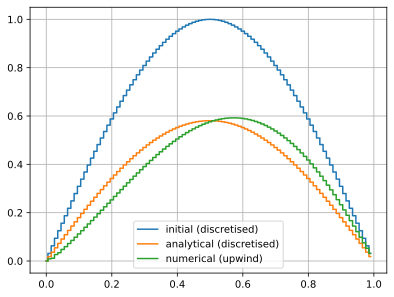

In [27]:
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot, show_anim

def plot(solution, x, t):
    y_true = solution.anal(x=x, t=t)
    y_pred = solution(x)
    fig = pyplot.figure()
    pyplot.step(x, solution.anal(x=x, t=0), label='initial (discretised)', where='mid')
    pyplot.step(x, y_true, label='analytical (discretised)', where='mid')
    pyplot.step(x, y_pred, label=f'numerical (upwind)', where='mid')
    pyplot.legend()
    pyplot.grid()
    return fig, MRE(y_true, y_pred)
plt, err = plot(num, x, t_max)
show_plot(fig=plt)

In [28]:
print(f"Mean Relative Errors equals: {err}")

Mean Relative Errors equals: 0.20735065460711946


Mean Relative Error is about 20%. One can say it is not great, not terrible, but as we can also see from the plot numerical solution has a tendency to deform the original shape.